<a href="https://colab.research.google.com/github/rpdieego/Reinforcement_Learning/blob/master/Reinforcement_Learning_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Temporal Difference Learning

#### TD Prediction Problem | TD(0)

In [0]:
#import relevant libraries
import numpy as np
import matplotlib.pyplot as plt


In [0]:
# definitions

#convergence parameter
conv_parameter = 10e-4

# discount factor
gamma = 0.9

# learning rate
alpha = 0.1

# Action Space
ALL_POSSIBLE_ACTIONS = ('U','D','L','R')

In [0]:
#grid world class

class Grid: # Environment
  def __init__ (self, rows, cols, start):
    self.rows = rows
    self.cols = cols
    self.i = start[0]
    self.j = start[1]

  def set(self, rewards, actions):
    # rewards is a dict of: (i,j): r
    # actions is a dict of: (i,j): A
    self.rewards = rewards
    self.actions = actions

  def set_state(self,s):
    #force state
    self.i = s[0]
    self.j = s[1]

  def current_state(self):
    #return the current state
    return (self.i, self.j)
  
  def is_terminal(self, s):
    #if state is not listed in the actions dictionary, it means it's a terminal state
    return s not in self.actions

  def get_next_state(self, s, a):
    i, j = s[0], s[1]
    if a in self.actions[(i,j)]:
      if a == 'U':
        i -= 1
      elif a =='D':
        i += 1
      elif a == 'R':
        j += 1
      elif a == 'L':
        j -= 1
    return i,j

  def move(self, action):
    # check if legal move first
    if action in self.actions[(self.i, self.j)]:
      if action == 'U':
        self.i -= 1
      elif action == 'D':
        self.i += 1
      elif action == 'R':
        self.j += 1
      elif action == 'L':
        self.j -= 1
    return self.rewards.get((self.i, self.j), 0)

  def undo_move(self, action):
    if action == 'U':
      self.i += 1
    elif action == 'D':
      self.i -= 1
    elif action == 'R':
      self.j -= 1
    elif action == 'L':
      self.j += 1
    #should never happen
    assert(self.current_state() in self.all_states())
  
  def game_over(self):
    #true if in a state where no actions are possible
    return (self.i,self.j) not in self.actions

  def all_states(self):
    #either a position that has possible next actions or a positions that yields a reward
    return set(self.actions.keys()) | set(self.rewards.keys())


In [0]:
# define grid environment

def standard_grid():
  g = Grid(3, 4, (2,0))
  rewards = {(0,3): 1, (1,3): -1}
  actions = {
      (0,0): ('D','R'),
      (0,1): ('L','R'),
      (0,2): ('L','D','R'),
      (1,0): ('U','D'),
      (1,2): ('U', 'D', 'R'),
      (2,0): ('U','R'),
      (2,1): ('L','R'),
      (2,2): ('L','R','U'),
      (2,3): ('L','U')
  }
  g.set(rewards, actions)
  return g

In [0]:
#define grid environment with step penalties

def negative_grid(step_cost=-0.1):
  # in this game we want to try to minimize the number of moves
  # so we will penalize every move
  g = standard_grid()
  g.rewards.update({
    (0, 0): step_cost,
    (0, 1): step_cost,
    (0, 2): step_cost,
    (1, 0): step_cost,
    (1, 2): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 2): step_cost,
    (2, 3): step_cost,
  })
  return g

In [0]:
# auxiliar function to print values
def print_values(V,g):
  for i in range(g.rows):
    print('-------------------------------')
    for j in range(g.cols):
      v = V.get((i,j),0)
      if v>= 0:
        print(" %.2f|" % v, end="")
      else:
        print("%.2f|" % v, end="") # - sign take up an extra space
    print('')

In [0]:
# auxiliar function to print policy
def print_policy(P,g):
  print('Policy \n')
  for i in range(g.rows):
    print('-----------------------------')
    for j in range(g.cols):
      a = P.get((i,j),' ')
      print("  %s  |" % a, end='')
    print('')
  print('\n')

In [0]:
def random_action(a, eps=0.1):
  #we'll use episilon-soft to ensure all states are visited
  p = np.random.random()
  if p < (1-eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [0]:
def play_game(grid,policy):
  #return a list of states and corresponding rewards
  #start at the designated start state (2,0)
  s = (2,0)
  grid.set_state(s)
  #list of tuples of (state, reward)
  states_and_rewards = [(s,0)]
  while not grid.game_over():
    a = policy[s]
    a = random_action(a)
    r = grid.move(a)
    s = grid.current_state()
    states_and_rewards.append((s,r))
  return states_and_rewards

In [0]:
#### main

#define grid
grid = standard_grid()

#print rewards
print('Rewards: ')
print_values(grid.rewards, grid)
print('\n')

# state -> action
policy = {
    (2,0): 'U',
    (1,0): 'U',
    (0,0): 'R',
    (0,1): 'R',
    (0,2): 'R',
    (1,2): 'R',
    (2,1): 'R',
    (2,2): 'R',
    (2,3): 'U',
}

print('Initial Policy:')
print_policy(policy,grid)
print('\n')

# initialize V(s) and returns
V = {}
states = grid.all_states()

# populate V[s] = 0 for all possible states
for s in states:
  V[s] = 0

#repeat until convergence
for it in range(1000):

  #generate an episode
  states_and_rewards = play_game(grid, policy)

  # first (s,r) = (initial_state, 0)
  # last (s,r) = (terminal_state, final_reward)
  # value of terminal state is 0 by definition
  for t in range(len(states_and_rewards) - 1):
    s, _ = states_and_rewards[t]
    s2, r = states_and_rewards[t+1]
    # update V(s) as we experience the episode
    V[s] = V[s] + alpha*(r + gamma*V[s2] - V[s])



print('Values:')
print_values(V, grid)
print('\n')

print('Final Policy:')
print_policy(policy,grid)
print('\n')

Rewards: 
-------------------------------
 0.00| 0.00| 0.00| 1.00|
-------------------------------
 0.00| 0.00| 0.00|-1.00|
-------------------------------
 0.00| 0.00| 0.00| 0.00|


Initial Policy:
Policy 

-----------------------------
  R  |  R  |  R  |     |
-----------------------------
  U  |     |  R  |     |
-----------------------------
  U  |  R  |  R  |  U  |




Values:
-------------------------------
 0.77| 0.88| 0.99| 0.00|
-------------------------------
 0.67| 0.00|-0.80| 0.00|
-------------------------------
 0.58|-0.38|-0.69|-0.92|


Final Policy:
Policy 

-----------------------------
  R  |  R  |  R  |     |
-----------------------------
  U  |     |  R  |     |
-----------------------------
  U  |  R  |  R  |  U  |






#### TD Control Problem - SARSA

In [0]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

rewards:
-------------------------------
-0.10|-0.10|-0.10| 1.00|
-------------------------------
-0.10| 0.00|-0.10|-1.00|
-------------------------------
-0.10|-0.10|-0.10|-0.10|
it: 0
it: 2000
it: 4000
it: 6000
it: 8000


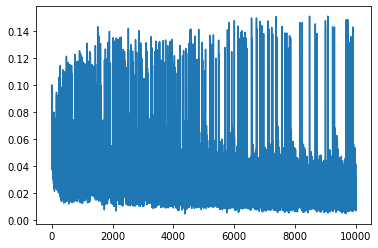

update counts:
-------------------------------
 0.18| 0.18| 0.18| 0.00|
-------------------------------
 0.18| 0.00| 0.04| 0.00|
-------------------------------
 0.18| 0.03| 0.03| 0.00|
values:
-------------------------------
 0.55| 0.78| 1.00| 0.00|
-------------------------------
 0.32| 0.00| 0.65| 0.00|
-------------------------------
 0.14| 0.08| 0.21| 0.17|
policy:
Policy 

-----------------------------
  R  |  R  |  R  |     |
-----------------------------
  U  |     |  U  |     |
-----------------------------
  U  |  R  |  U  |  L  |




In [0]:
# NOTE: if we use the standard grid, there's a good chance we will end up with
# suboptimal policies
# e.g.
# ---------------------------
#   R  |   R  |   R  |      |
# ---------------------------
#   R* |      |   U  |      |
# ---------------------------
#   U  |   R  |   U  |   L  |
# since going R at (1,0) (shown with a *) incurs no cost, it's OK to keep doing that.
# we'll either end up staying in the same spot, or back to the start (2,0), at which
# point we whould then just go back up, or at (0,0), at which point we can continue
# on right.
# instead, let's penalize each movement so the agent will find a shorter route.
#
# grid = standard_grid()
grid = negative_grid(step_cost=-0.1)

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

# no policy initialization, we will derive our policy from most recent Q

# initialize Q(s,a)
Q = {}
states = grid.all_states()
for s in states:
  Q[s] = {}
  for a in ALL_POSSIBLE_ACTIONS:
    Q[s][a] = 0

# let's also keep track of how many times Q[s] has been updated
update_counts = {}
update_counts_sa = {}
for s in states:
  update_counts_sa[s] = {}
  for a in ALL_POSSIBLE_ACTIONS:
    update_counts_sa[s][a] = 1.0

# repeat until convergence
t = 1.0
deltas = []
for it in range(10000):

  # t for learning rate and epsilon
  if it % 100 == 0:
    t += 1e-2

  # instead of 'generating' an epsiode, we will PLAY
  # an episode within this loop
  s = (2, 0) # start state
  grid.set_state(s)

  # the first (s, r) tuple is the state we start in and 0
  # (since we don't get a reward) for simply starting the game
  # the last (s, r) tuple is the terminal state and the final reward
  # the value for the terminal state is by definition 0, so we don't
  # care about updating it.
  a = max_dict(Q[s])[0]
  a = random_action(a, eps=0.5/t)
  biggest_change = 0
  while not grid.game_over():
    r = grid.move(a)
    s2 = grid.current_state()

    # we need the next action as well since Q(s,a) depends on Q(s',a')
    # if s2 not in policy then it's a terminal state, all Q are 0
    a2 = max_dict(Q[s2])[0]
    a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

    # we will update Q(s,a) AS we experience the episode
    old_qsa = Q[s][a]
    Q[s][a] = Q[s][a] + alpha*(r + gamma*Q[s2][a2] - Q[s][a])
    biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

    # we would like to know how often Q(s) has been updated too
    update_counts[s] = update_counts.get(s,0) + 1

    # next state becomes current state
    s = s2
    a = a2

  deltas.append(biggest_change)

plt.plot(deltas)
plt.show()

# determine the policy from Q*
# find V* from Q*
policy = {}
V = {}
for s in grid.actions.keys():
  a, max_q = max_dict(Q[s])
  policy[s] = a
  V[s] = max_q

# what's the proportion of time we spend updating each part of Q?
print("update counts:")
total = np.sum(list(update_counts.values()))
for k, v in update_counts.items():
  update_counts[k] = float(v) / total
print_values(update_counts, grid)

print("values:")
print_values(V, grid)
print("policy:")
print_policy(policy, grid)

#### TD Control Problem - Q Learning

rewards:
-------------------------------
-0.10|-0.10|-0.10| 1.00|
-------------------------------
-0.10| 0.00|-0.10|-1.00|
-------------------------------
-0.10|-0.10|-0.10|-0.10|
it: 0
it: 2000
it: 4000
it: 6000
it: 8000


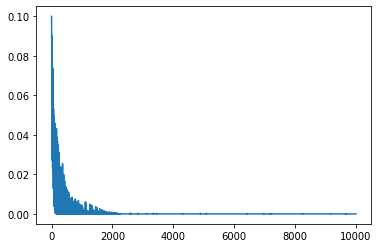

update counts:
-------------------------------
 0.15| 0.15| 0.17| 0.00|
-------------------------------
 0.15| 0.00| 0.06| 0.00|
-------------------------------
 0.19| 0.06| 0.06| 0.01|
values:
-------------------------------
 0.62| 0.80| 1.00| 0.00|
-------------------------------
 0.46| 0.00| 0.80| 0.00|
-------------------------------
 0.31| 0.46| 0.62| 0.46|
policy:
Policy 

-----------------------------
  R  |  R  |  R  |     |
-----------------------------
  U  |     |  U  |     |
-----------------------------
  U  |  R  |  U  |  L  |




In [0]:
# NOTE: if we use the standard grid, there's a good chance we will end up with
# suboptimal policies
# e.g.
# ---------------------------
#   R  |   R  |   R  |      |
# ---------------------------
#   R* |      |   U  |      |
# ---------------------------
#   U  |   R  |   U  |   L  |
# since going R at (1,0) (shown with a *) incurs no cost, it's OK to keep doing that.
# we'll either end up staying in the same spot, or back to the start (2,0), at which
# point we whould then just go back up, or at (0,0), at which point we can continue
# on right.
# instead, let's penalize each movement so the agent will find a shorter route.
#
# grid = standard_grid()
grid = negative_grid(step_cost=-0.1)

# print rewards
print("rewards:")
print_values(grid.rewards, grid)

# no policy initialization, we will derive our policy from most recent Q

# initialize Q(s,a)
Q = {}
states = grid.all_states()
for s in states:
  Q[s] = {}
  for a in ALL_POSSIBLE_ACTIONS:
    Q[s][a] = 0

# let's also keep track of how many times Q[s] has been updated
update_counts = {}
update_counts_sa = {}
for s in states:
  update_counts_sa[s] = {}
  for a in ALL_POSSIBLE_ACTIONS:
    update_counts_sa[s][a] = 1.0

# repeat until convergence
t = 1.0
deltas = []
for it in range(10000):
  if it % 100 == 0:
    t += 1e-2
  if it % 2000 == 0:
    print("it:", it)

  # instead of 'generating' an epsiode, we will PLAY
  # an episode within this loop
  s = (2, 0) # start state
  grid.set_state(s)

  # the first (s, r) tuple is the state we start in and 0
  # (since we don't get a reward) for simply starting the game
  # the last (s, r) tuple is the terminal state and the final reward
  # the value for the terminal state is by definition 0, so we don't
  # care about updating it.
  a, _ = max_dict(Q[s])
  biggest_change = 0
  while not grid.game_over():
    a = random_action(a, eps=0.5/t) # epsilon-greedy
    # random action also works, but slower since you can bump into walls
    # a = np.random.choice(ALL_POSSIBLE_ACTIONS)
    r = grid.move(a)
    s2 = grid.current_state()

    # we will update Q(s,a) AS we experience the episode
    old_qsa = Q[s][a]
    # the difference between SARSA and Q-Learning is with Q-Learning
    # we will use this max[a']{ Q(s',a')} in our update
    # even if we do not end up taking this action in the next step
    a2, max_q_s2a2 = max_dict(Q[s2])
    Q[s][a] = Q[s][a] + alpha*(r + gamma*max_q_s2a2 - Q[s][a])
    biggest_change = max(biggest_change, np.abs(old_qsa - Q[s][a]))

    # we would like to know how often Q(s) has been updated too
    update_counts[s] = update_counts.get(s,0) + 1

    # next state becomes current state
    s = s2
    a = a2
    
  deltas.append(biggest_change)

plt.plot(deltas)
plt.show()

# determine the policy from Q*
# find V* from Q*
policy = {}
V = {}
for s in grid.actions.keys():
  a, max_q = max_dict(Q[s])
  policy[s] = a
  V[s] = max_q

# what's the proportion of time we spend updating each part of Q?
print("update counts:")
total = np.sum(list(update_counts.values()))
for k, v in update_counts.items():
  update_counts[k] = float(v) / total
print_values(update_counts, grid)

print("values:")
print_values(V, grid)
print("policy:")
print_policy(policy, grid)